In [1]:
%matplotlib inline
#load_ext nengo.ipynb

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nengo
from nengo.utils.ensemble import tuning_curves
from PopulationMode import PopulationModeModel
import nengo.utils.numpy as npext
# from nengo_gui.ipython import IpythonViz


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Variables initialization (TODO: Implement different versions of variables as covered in the article)
tau_ref = 0.002 # refactory time
tau_RC = 0.02 # membrane RC time constant
synapse = 0.01
n = 10 # number of neurons
sim_time = 5
intercepts = -1 + 2*np.random.rand(1,n)[0]
max_rates = 80 + 50*np.random.rand(1,n)[0]
v0 = 0
dt = 0.001
rad = 3
dim = 2
seed = None

In [3]:
# Initial model & connections
model = nengo.Network(label="test_populationMode", seed=seed)
with model:
    if dim == 1:
        stim = nengo.Node(output=lambda t: 2*(t % 1) - 1)
        pre = nengo.Ensemble(n, dimensions=1, intercepts=intercepts,
                max_rates=max_rates, neuron_type=nengo.LIF(tau_RC, tau_ref, v0),
                label="Pre", radius=rad, seed=seed)
        post = nengo.Ensemble(n, dimensions=1, intercepts=intercepts,
                max_rates=max_rates, neuron_type=nengo.LIF(tau_RC, tau_ref, v0),
                label="Post", radius=rad, seed=seed)
        end = nengo.Node(None, size_in=1) # For second population's decoder

    elif dim == 2:
        stim = nengo.Node(output=lambda t: 2*(t % 1) - 1, size_out=2)
        pre = nengo.Ensemble(n, dimensions=2, intercepts=intercepts,
                max_rates=max_rates, neuron_type=nengo.LIF(tau_RC, tau_ref, v0),
                label="Pre", radius=2)
        post = nengo.Ensemble(n, dimensions=2, intercepts=intercepts,
                max_rates=max_rates, neuron_type=nengo.LIF(tau_RC, tau_ref, v0),
                label="Post", radius=2)
        end = nengo.Node(None, size_in=2)

        
    # Add connections
    nengo.Connection(stim, pre)
    nengo.Connection(pre, pre) 
    nengo.Connection(post, post)
    conn_stim = nengo.Connection(pre, post)
    conn_end = nengo.Connection(post, end)
    
    origins = [conn_stim.pre]
    stim_probe = nengo.Probe(stim)
    pre_probe = nengo.Probe(pre, synapse=synapse)
    post_probe = nengo.Probe(post, synapse=synapse)
    end_probe = nengo.Probe(end)
    
#     IpythonViz(model)

In [4]:
# Simulate the model for second(s)
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(sim_time)

# Surrogate population
x_vals = np.linspace(-rad, rad, num=sim_time/dt)
if dim > 1:
    x_vals = np.asarray(npext.meshgrid_nd(*(dim * [x_vals])))
    
eval_points_pre, rates_pre = tuning_curves(pre, sim, inputs=x_vals)
eval_points_post, rates_post = tuning_curves(post, sim, inputs=x_vals)
decoders = [sim.data[conn_stim].weights, sim.data[conn_end].weights]
rates = [rates_pre.T, rates_post.T]
print rates_pre.shape
input = sim.data[stim_probe]
outputs = [sim.data[pre_probe], sim.data[post_probe]]

params = {'population':post,'origins':origins,'x_vals':eval_points_post,
          'rates':rates,'decoders':decoders,'timerange':sim.trange(),'dt':dt,
          'outputs':outputs
         }

surr_pop = PopulationModeModel(n, sim_time, dim, params=params)


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


(2, 1000, 5000)


actual shape: (1000, 2), ideal shape: (1000, 2)
self.bias_values_sim: [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ..., 
 [-0.15071077 -0.38733798]
 [-1.07854878 -0.91765641]
 [-1.16236121 -0.24624579]]
and its shape: (1000, 2)
self.bias_values_est: [[  1.39662783e-012   1.20269626e-012]
 [  1.39476007e-012  -1.20189179e-012]
 [  1.25304118e-011   3.60245269e-012]
 ..., 
 [ -1.50752297e-001   0.00000000e+000]
 [ -1.07929368e+000  -4.94065646e-324]
 [ -1.16236121e+000  -4.94065646e-324]]
and its shape: (1000, 2)


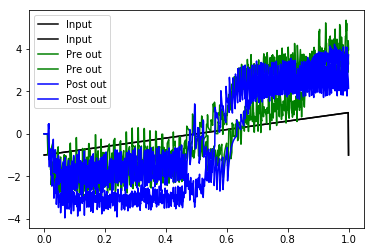

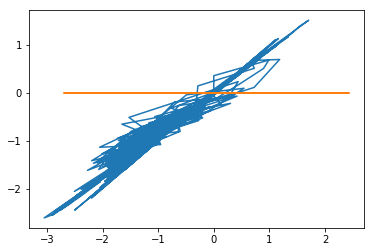

In [5]:
# Validate the bias model of the surrogate model
surr_pop.createBiasModel(mode="lin_interp")
# print surr_pop.bias_values_est

plt.figure()
plt.plot(sim.trange(), input, 'k', label="Input")
plt.plot(sim.trange(), surr_pop.ideal_values,'g', label="Pre out")
plt.plot(sim.trange(), surr_pop.actual_values,'b', label="Post out")
plt.legend()

# plt.plot(eval_points_post, surr_pop.bias_values_sim.T,'k',label='Simulated bias')
# plt.plot(eval_points_post, surr_pop.bias_values_est.T,'g',label='Modeled bias')
# plt.plot(eval_points_post, (surr_pop.bias_values_sim-surr_pop.bias_values_est).T,'b',label='Difference')
# plt.legend()

plt.figure()
plt.plot(surr_pop.bias_values_sim, surr_pop.bias_values_est)

In [6]:
print surr_pop.bias_values_sim.T[0]
# Validate the noise model of the surrogate model

# ramp_ranges = np.array([[-0.1, 0.1], [1.25, 1.75]])
# Get the random range of points from the function

# surr_pop.createNoiseModel()


[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.98874225
  0.89465099  0.47065293  0.02629189 -0.38949419 -0.38674207 -0.3499387
 -0.31663763 -0.28650557  0.72950129  0.66008006  1.18483498  0.72555316
 -0.49867738 -0.45122196 -0.40828251 -0.46252348 -0.76503842 -0.0423539
  0.12623746 -0.79596849 -0.72022207 -0.99821375 -0.90322115 -1.06226045
 -0.49090827  0.54455008 -0.25337306 -1.13945429 -1.12411507 -0.70492467
  0.37594416 -0.59021445 -0.53404812 -0.8827992  -0.72024037 -0.58447588
 -0.47157092 -0.42669501 -0.72495037 -1.05553471 -0.9550873  -2.05369691
 -0.86951956 -0.28986504 -0.26228074 -0.61049534 -0.95197151 -0.86137945
 -1.68960122 -1.03190562 -1.52522884  0.43775242  0.30300058 -0.46426698
 -0.26970721 -1.39922621 -1.26607223 -0.83337282 -0.75406691 -0.37895633
 -0.74246635 -0.26799674 -1.08546179 -0.98216645 -1.23523082 -1.11768306
 -1.01132146 -1.65351475  0.30170574 -0.98372809 